## 导入相关包

In [1]:
import matplotlib.pyplot as plt
from utils.PV_array import PVModule
from utils.utils import time_alignment
from utils.utils import sun_earth_distance
import pandas as pd
import numpy as np
import scienceplots
import os
plt.style.use(['science', 'no-latex', 'cjk-sc-font'])


## 数据加载

In [2]:
position_precise = pd.read_parquet('../data/position_precise.parquet')
state_precise = pd.read_parquet('../data/state_precise.parquet')
attitude_precise = pd.read_parquet('../data/attitude_precise.parquet')


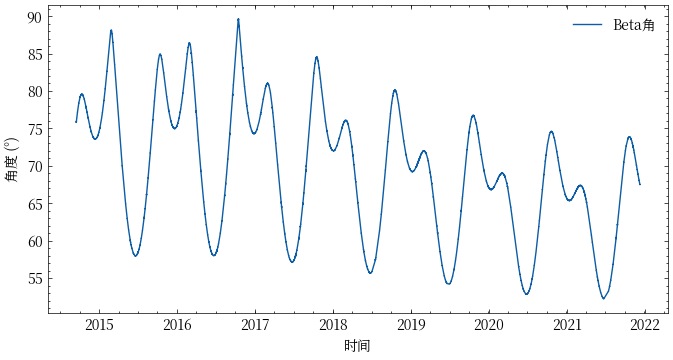

In [3]:
# Beta角绘制
plt.figure(figsize=(8, 4))
plt.plot(position_precise['时间'], position_precise['Beta角(度)'], label='Beta角')
plt.xlabel('时间')
plt.ylabel('角度 (°)')
plt.legend()
plt.savefig('plot/Beta角.png', bbox_inches='tight', dpi=300)
plt.show()

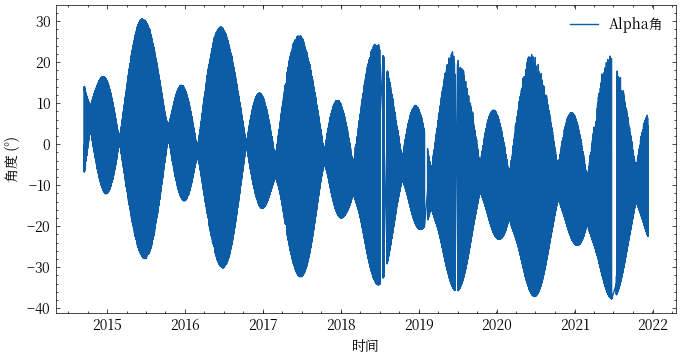

In [4]:
# Alpha角绘制
plt.figure(figsize=(8, 4))
plt.plot(position_precise['时间'], position_precise['Alpha角(度)'], label='Alpha角')
plt.xlabel('时间')
plt.ylabel('角度 (°)')
plt.legend()
plt.savefig('plot/Alpha角.png', bbox_inches='tight', dpi=300)
plt.show()

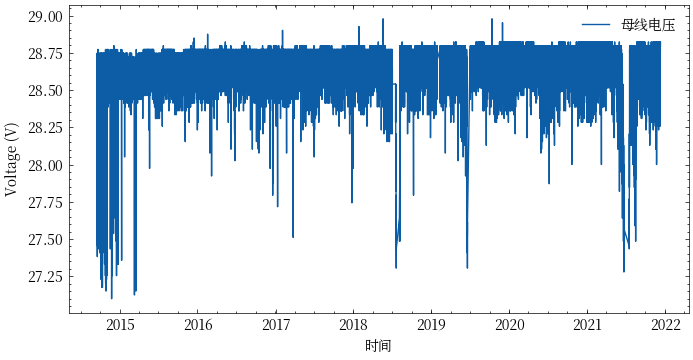

In [5]:
# Alpha角绘制
plt.figure(figsize=(8, 4))
plt.plot(state_precise['时间'], state_precise['28V母线电压-TTC采集'], label='母线电压')
plt.xlabel('时间')
plt.ylabel('Voltage (V)')
plt.legend()
plt.savefig('plot/Voltage.png', bbox_inches='tight', dpi=300)
plt.show()


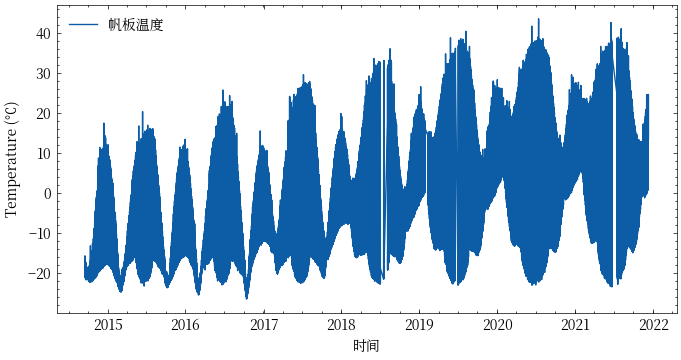

In [6]:
# Alpha角绘制
plt.figure(figsize=(8, 4))
plt.plot(state_precise['时间'], state_precise['帆板温度[-X]'], label='帆板温度')
plt.xlabel('时间')
plt.ylabel('Temperature (℃)')
plt.legend()
plt.savefig('plot/帆板温度[-Y].png', bbox_inches='tight', dpi=300)
plt.show()


In [9]:
distance_precise = pd.read_parquet('../data/distance.parquet')
distance = distance_precise['distance'].values
# 计算光照强度
average_solar_constant = 1366  # W/m²
average_distance = np.mean(distance)
irradiance = average_solar_constant * (average_distance / distance) ** 2

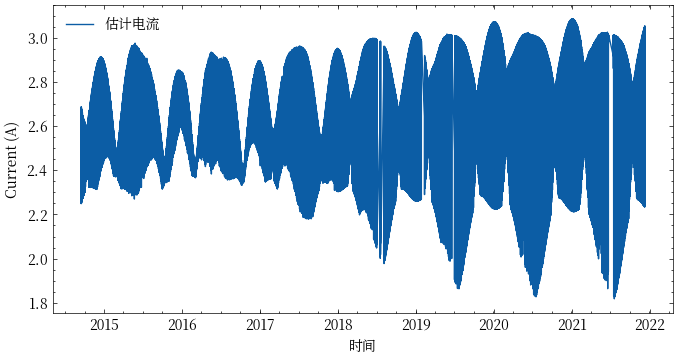

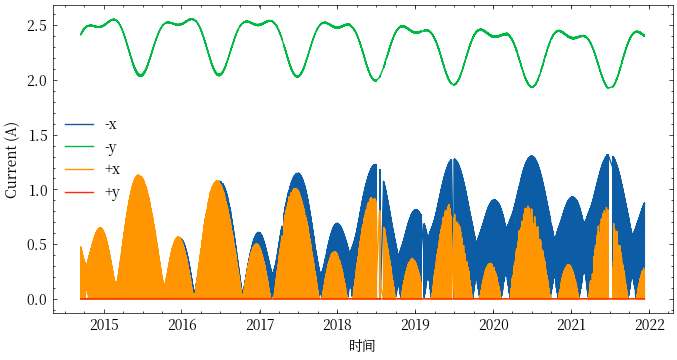

In [11]:
from utils.PV_array import PVModule
x_neg_config = [
    {'count': 36, 'series': 18, 'area': 0.0604*0.0398},
    {'count': 126, 'series': 18, 'area': 0.0403*0.0306}
]
y_neg_config = [
    {'count': 108, 'series': 18, 'area': 0.0604*0.0398}
]
x_pos_config = [
    {'count': 36, 'series': 18, 'area': 0.0604*0.0398},
    {'count': 126, 'series': 18, 'area': 0.0403*0.0306}
]
y_pos_config = [
    {'count': 180, 'series': 18, 'area': 0.0403*0.0306}
]

x_neg_module = PVModule(x_neg_config)
y_neg_module = PVModule(y_neg_config)
x_pos_module = PVModule(x_pos_config)
y_pos_module = PVModule(y_pos_config)
I_y_neg, P_y_neg = y_neg_module.calculate(V=state_precise['28V母线电压-TTC采集'], G=irradiance, T=state_precise['帆板温度[-Y]'], factor=-position_precise['太阳矢量计算Y'])
I_x_neg, P_x_neg = x_neg_module.calculate(V=state_precise['28V母线电压-TTC采集'], G=irradiance, T=state_precise['帆板温度[-X]'], factor=-position_precise['太阳矢量计算X'])
I_x_pos, P_x_pos = x_pos_module.calculate(V=state_precise['28V母线电压-TTC采集'], G=irradiance, T=state_precise['帆板温度[+X]'], factor=position_precise['太阳矢量计算X'])
I_y_pos, P_y_pos = y_pos_module.calculate(V=state_precise['28V母线电压-TTC采集'], G=irradiance, T=state_precise['帆板温度[+Y]'], factor=position_precise['太阳矢量计算Y'])
I_total = (I_x_neg + I_y_neg + I_x_pos + I_y_pos)*0.93

plt.figure(figsize=(8, 4))
plt.plot(position_precise['时间'], I_total, label='估计电流')
plt.xlabel('时间')
plt.ylabel('Current (A)')
plt.legend()
plt.savefig('plot/估计电流.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(position_precise['时间'], I_x_neg, label='-x')
plt.plot(position_precise['时间'], I_y_neg, label='-y')
plt.plot(position_precise['时间'], I_x_pos, label='+x')
plt.plot(position_precise['时间'], I_y_pos, label='+y')

plt.xlabel('时间')
plt.ylabel('Current (A)')
plt.legend()
plt.savefig('plot/分电流.png', bbox_inches='tight', dpi=300)
plt.show()


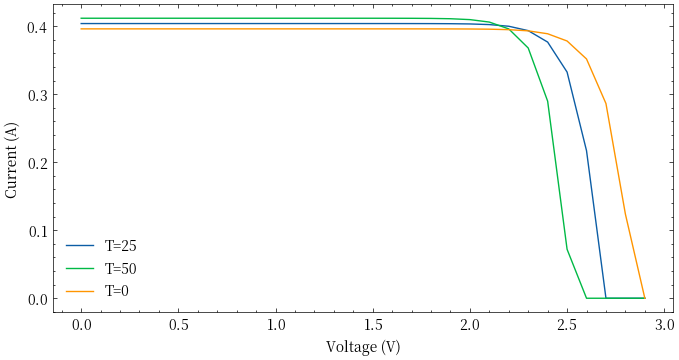

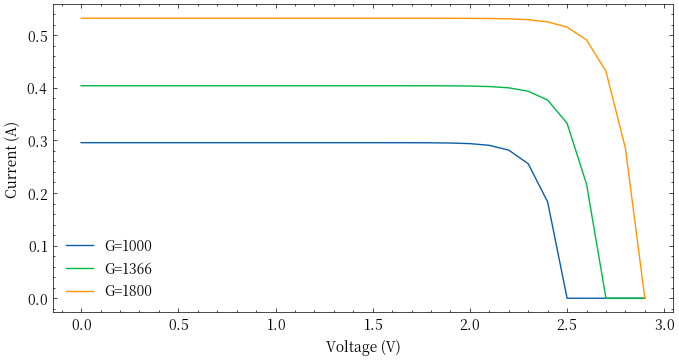

In [13]:
config = [
    {'count': 1, 'series': 1, 'area': 0.0604*0.0398}
]
module = PVModule(config)
#绘制U-I曲线
V=np.arange(0,3,0.1)
I_1, P_1 = module.calculate(V=V, G=1366, T=25, factor=1)
I_2, P_2 = module.calculate(V=V, G=1366, T=50, factor=1)
I_3, P_3 = module.calculate(V=V, G=1366, T=0, factor=1)
plt.figure(figsize=(8, 4))
plt.plot(V, I_1, label='T=25')
plt.plot(V, I_2, label='T=50')
plt.plot(V, I_3, label='T=0')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


#绘制U-I曲线
V=np.arange(0,3,0.1)
I_1, P_1 = module.calculate(V=V, G=1366, T=25, factor=1000/1366)
I_2, P_2 = module.calculate(V=V, G=1366, T=25, factor=1366/1366)
I_3, P_3 = module.calculate(V=V, G=1366, T=25, factor=1800/1366)
plt.figure(figsize=(8, 4))
plt.plot(V, I_1, label='G=1000')
plt.plot(V, I_2, label='G=1366')
plt.plot(V, I_3, label='G=1800')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


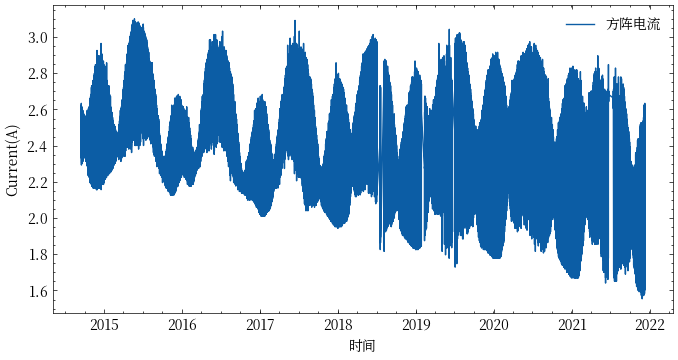

In [14]:
# 方阵电流
plt.figure(figsize=(8, 4))
plt.plot(state_precise['时间'], state_precise['方阵电流'], label='方阵电流')
plt.xlabel('时间')
plt.ylabel('Current(A)')
plt.legend()
plt.savefig('plot/实际电流.png', bbox_inches='tight', dpi=300)
plt.show()

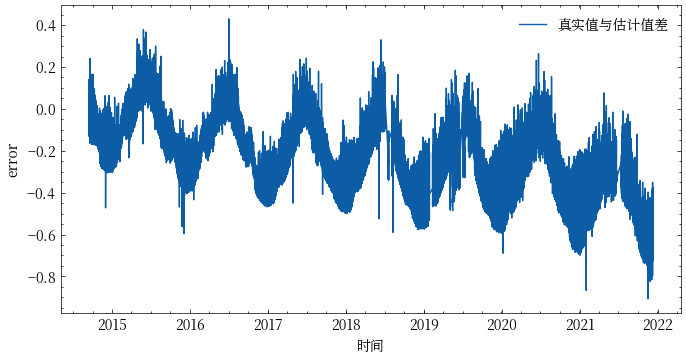

In [15]:
# 方阵电流
plt.figure(figsize=(8, 4))
plt.plot(state_precise['时间'], (state_precise['方阵电流']-I_total), label='真实值与估计值差')
plt.xlabel('时间')
plt.ylabel('error')
plt.legend()
plt.savefig('plot/误差.png', bbox_inches='tight', dpi=300)
plt.show()

## 绘制段落预测误差

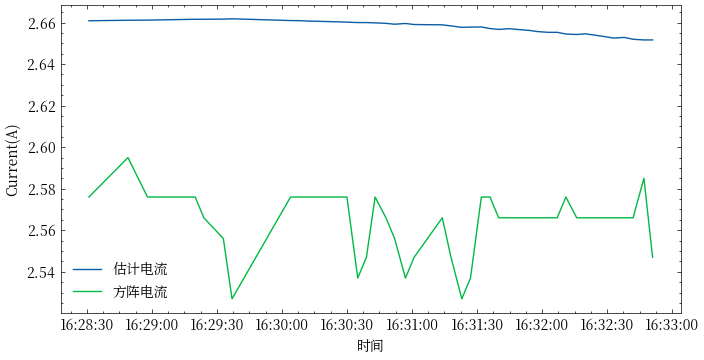

In [23]:
segment_id = 23
state_segment_precise = state_precise[state_precise['segment'] == segment_id]
position_segment_precise = position_precise[position_precise['segment'] == segment_id]

I_x_neg, P_x_neg = x_neg_module.calculate(V=state_segment_precise['28V母线电压-TTC采集'], G=1366, T=state_segment_precise['帆板温度[-X]'], factor=-position_segment_precise['太阳矢量计算X'])
I_y_neg, P_y_neg = y_neg_module.calculate(V=state_segment_precise['28V母线电压-TTC采集'], G=1366, T=state_segment_precise['帆板温度[-Y]'], factor=-position_segment_precise['太阳矢量计算Y'])
I_x_pos, P_x_pos = x_pos_module.calculate(V=state_segment_precise['28V母线电压-TTC采集'], G=1366, T=state_segment_precise['帆板温度[+X]'], factor=position_segment_precise['太阳矢量计算X'])
I_y_pos, P_y_pos = y_pos_module.calculate(V=state_segment_precise['28V母线电压-TTC采集'], G=1366, T=state_segment_precise['帆板温度[+Y]'], factor=position_segment_precise['太阳矢量计算Y'])
I_total = (I_x_neg + I_y_neg + I_x_pos + I_y_pos)*0.92
# I_total = (I_x_neg + I_y_neg*0.8 + I_x_pos + I_y_pos)*1.1
# 绘制各个电流曲线
plt.figure(figsize=(8, 4))
plt.plot(state_segment_precise['时间'], I_total, label='估计电流')
plt.plot(state_segment_precise['时间'], state_segment_precise['方阵电流'], label='方阵电流')
plt.xlabel('时间')
plt.ylabel('Current(A)')
plt.legend()
plt.savefig(f'plot/段落{segment_id}预测误差.png', bbox_inches='tight', dpi=300)
plt.show()
